# Chapter 8: Vicsek Model

<img src="VM_fig_01.jpg" alt="title" width="600px" />

## Motivation

**Vicsek model**: minimal model that describes collective phenomena such as swarm-like behaviour.

Has a second-order phase transition to a kinetic, swarm-like phase. Order parameter: noise.

**Key advantages**:
- Simple: few base rules
- Describes complex behaviour (macroscale and microscale)
- Can be combined with other models and adapted to different cases



### Applications

**Physics**
- Active matter systems

**Biology**
- Animal behaviour
- Swarm intelligence

**Control theory**
- Crowd control
- Synchronization
- Self-organizing and adaptive swarms

**Computer animation**
- Rendering of flocks and herds in computer games and film industry
- Virtual reality


## Application example: Collective dynamics of pedestrians in a corridor: An approach combining social force and Vicsek models

[Collective dynamics of pedestrians in a corridor: An approach combining social force and Vicsek models](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.102.022307)

<img src="VM_fig_02.png" alt="title" width="600px" />

## The standard Vicsek model

**Arena**: Square, side $L$.

**Agents** also referred to as *particles*.

Total number: $N$

Position and orientation: $x_{i}$, $y_{i}$, $\theta_{i}$

Speed: $v$

Velocity: $\mathbf{v}_{j,n} = (v \cos{\theta_{j,n}}) \, \hat{\mathbf{x}} + (v \sin{\theta_{j,n}})\, \hat{\mathbf{y}}$

Flocking radius: $R_{\rm f}$




**Periodic boundary conditions**

$$
\begin{array}{lcr}
    \left\{
    \begin{array}{ll}
        x \to x+L 
        & 
        \mathrm{if}\, \, \, x < -\frac{L}{2} 
        \\[5pt]
        x \to x 
        & 
        \mathrm{if}\, \, \, -\frac{L}{2} \le x \le \frac{L}{2} 
        \\[5pt]
        x \to x-L 
        & 
        \mathrm{if}\, \, \, x > \frac{L}{2}
    \end{array}
    \right.
    & \, \, \, &
    \left\{
    \begin{array}{ll}
        y \to y+L 
        & 
        \mathrm{if}\, \, \, y < -\frac{L}{2}
        \\[5pt]
        y \to y 
        & 
        \mathrm{if}\, \, \, -\frac{L}{2} \le y \le \frac{L}{2} 
        \\[5pt]
        y \to y-L 
        & 
        \mathrm{if}\, \, \, y > \frac{L}{2} 
    \end{array}
    \right.
\end{array}    
$$

<img src="VM_fig_03.png" alt="title" width="600px" />

Function to obtain the replica of the positions.

In [1]:
import math
import numpy as np 
    
def replicas(x, y, L):
    """
    Function to generate replicas of a single particle.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """    
    xr = np.zeros(9)
    yr = np.zeros(9)

    for i in range(3):
        for j in range(3):
            xr[3 * i + j] = x + (j - 1) * L
            yr[3 * i + j] = y + (i - 1) * L
    
    return xr, yr

Function to implement periodic boundary conditions.

In [2]:
def pbc(x, y, L):
    """
    Function to enforce periodic boundary conditions on the positions.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """   
    
    outside_left = np.where(x < - L / 2)[0]
    x[outside_left] = x[outside_left] + L

    outside_right = np.where(x > L / 2)[0]
    x[outside_right] = x[outside_right] - L

    outside_up = np.where(y > L / 2)[0]
    y[outside_up] = y[outside_up] - L

    outside_down = np.where(y < - L / 2)[0]
    y[outside_down] = y[outside_down] + L
    
    return x, y

### Interaction rule

At each time step, each particle collects information from all the particles **in its flocking area** and adjusts its orientation: 

$$
\theta_{j,n+1} 
    = \left\langle \theta_{k,n} \right\rangle + \eta W_{n} \Delta t,
$$

$\left\langle \theta_{k,n} \right\rangle$ : interaction rule

$\eta$ : noise

$W_{n}$: random number from a Gaussian distribution ($\mu=0$ and $\sigma = 1$)

The average $\left\langle \theta_{k,n} \right\rangle$ is a circular average: 

$$
 \left\langle \theta_{k,n} \right\rangle = \mathrm{atan2}\left(
 \left\langle \sin{\phi_{k, n}}  \right\rangle
 , 
 \left\langle \cos{\phi_{k, n}}  \right\rangle
 \right)
$$

The average for particle $j$ is calculated on the particles within the flocking radius only, i.e., indexed by $k$ with the condition $ \left| {\bf r}_{k,n} - {\bf r}_{j,n}\right| < R_{\rm f}$ (the particle $j$ itself is included in the averaging).


Let's simulate the Vicsek model.

Below a function that calculate the orientation at the next time step (interaction rule)

In [3]:
from functools import reduce

def interaction(x, y, theta, Rf, L):
    """
    Function to calculate the orientation at the next time step.
    
    Parameters
    ==========
    x, y : Positions.
    theta : Orientations.
    Rf : Flocking radius.
    L : Dimension of the squared arena.
    s : Discrete steps.
    """
    
    N = np.size(x)

    theta_next = np.zeros(N)
    
    # Preselect what particles are closer than Rf to the boundaries.
    replicas_needed = reduce( 
        np.union1d, (
            np.where(y + Rf > L / 2)[0], 
            np.where(y - Rf < - L / 2)[0],
            np.where(x + Rf > L / 2)[0],
            np.where(x - Rf > - L / 2)[0]
        )
    )

    for j in range(N):
        # Check if replicas are needed to find the nearest neighbours.
        if np.size(np.where(replicas_needed == j)[0]):
            # Use replicas.
            xr, yr = replicas(x[j], y[j], L)
            nn = []
            for nr in range(9):
                dist2 = (x - xr[nr]) ** 2 + (y - yr[nr]) ** 2 
                nn = np.union1d(nn, np.where(dist2 <= Rf ** 2)[0])
        else:
            dist2 = (x - x[j]) ** 2 + (y - y[j]) ** 2 
            nn = np.where(dist2 <= Rf ** 2)[0]
        
        # The list of nearest neighbours is set.
        nn = nn.astype(int)
        
        # Circular average.
        av_sin_theta = np.mean(np.sin(theta[nn]))
        av_cos_theta = np.mean(np.cos(theta[nn]))
        
        theta_next[j] = np.arctan2(av_sin_theta, av_cos_theta)
                   
    return theta_next

### Simulation 

Initialization of the system

In [4]:
N_part = 200  # Number of particles.
L = 100  # Dimension of the squared arena.
v = 1  # Speed.
Rf = 3  # Flocking radius.
eta = 0.1  # Noise.  Try values: 0.01, 0.3, 1.0, 2 * np.pi
dt = 1  # Time step.


# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
theta = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]


Simulation (animated) 

In [5]:
import time
from scipy.constants import Boltzmann as kB 
from tkinter import *

window_size = 600

rp = 0.5  # Plotting radius of a particle.
vp = 1  # Length of the arrow indicating the velocity direction.
line_width = 1  # Width of the arrow line.

N_skip = 1

tk = Tk()
tk.geometry(f'{window_size + 20}x{window_size + 20}')
tk.configure(background='#000000')

canvas = Canvas(tk, background='#ECECEC')  # Generate animation window 
tk.attributes('-topmost', 0)
canvas.place(x=10, y=10, height=window_size, width=window_size)

particles = []
for j in range(N_part):
    particles.append(
        canvas.create_oval(
            (x[j] - rp) / L * window_size + window_size / 2, 
            (y[j] - rp) / L * window_size + window_size / 2,
            (x[j] + rp) / L * window_size + window_size / 2, 
            (y[j] + rp) / L * window_size + window_size / 2,
            outline='#FF0000', 
            fill='#FF0000',
        )
    )

velocities = []
for j in range(N_part):
    velocities.append(
        canvas.create_line(
            x[j] / L * window_size + window_size / 2, 
            y[j] / L * window_size + window_size / 2,
            (x[j] + vp * np.cos(theta[j])) / L * window_size + window_size / 2, 
            (y[j] + vp * np.cos(theta[j])) / L * window_size + window_size / 2,
            width=line_width
        )
    )

step = 0

def stop_loop(event):
    global running
    running = False
tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
running = True  # Flag to control the loop.
while running:
    
    # Calculate next theta from the rule.
    dtheta = eta * (np.random.rand(N_part) - 0.5) * dt
    ntheta = interaction(x, y, theta, Rf, L) + dtheta
    nx = x + v * np.cos(ntheta)
    ny = y + v * np.sin(ntheta)
    
    # Reflecting boundary conditions.
    nx, ny = pbc(nx, ny, L)
        
    # Update animation frame.
    if step % N_skip == 0:        
        for j, particle in enumerate(particles):
            canvas.coords(
                particle,
                (nx[j] - rp) / L * window_size + window_size / 2,
                (ny[j] - rp) / L * window_size + window_size / 2,
                (nx[j] + rp) / L * window_size + window_size / 2,
                (ny[j] + rp) / L * window_size + window_size / 2,
            )
                    
        for j, velocity in enumerate(velocities):
            canvas.coords(
                velocity,
                nx[j] / L * window_size + window_size / 2,
                ny[j] / L * window_size + window_size / 2,
                (nx[j] + vp * np.cos(ntheta[j])) / L * window_size + window_size / 2,
                (ny[j] + vp * np.sin(ntheta[j])) / L * window_size + window_size / 2,
            )
                    
        tk.title(f'Time {step * dt:.1f} - Iteration {step}')
        tk.update_idletasks()
        tk.update()
        time.sleep(.01)  # Increase to slow down the simulation.    

    step += 1
    x[:] = nx[:]
    y[:] = ny[:]
    theta[:] = ntheta[:]  

tk.update_idletasks()
tk.update()
tk.mainloop()  # Release animation handle (close window to finish).

TclError: invalid command name ".!canvas"

Global alignment coefficient $\phi$

$$
    \psi_{n} 
    = 
    \frac{1}{N} \left| \sum_{j=1}^{N} \frac{{\bf v}_{j,n}}{v} \right|,
$$


In [6]:
def global_alignment(theta):
    """
    Function to calculate the global alignment coefficient.
    
    Parameters
    ==========
    theta : Orientations.
    """
    
    N = np.size(theta)
    
    global_direction_x = np.sum(np.sin(theta))
    global_direction_y = np.sum(np.cos(theta))
        
    psi = np.sqrt(global_direction_x ** 2 + global_direction_y ** 2) / N
    
                   
    return psi


Clustering coefficient $c$

$$
    c_{n} 
    = 
    \frac{ \displaystyle  {\rm count} \left\{ A_{i,n} < \pi\, R_{\rm f}^2 \right\} }{N}
$$

In [7]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def area_polygon(vertices):
    """
    Function to calculate the area of a Voronoi region given its vertices.
    
    Parameters
    ==========
    vertices : Coordinates (array, 2 dimensional).
    """    
    
    N, dim = vertices.shape
    
    # dim is 2.
    # Vertices are listed consecutively.
    
    A = 0
    
    for i in range(N-1):
        # Below is the formula of the area of a triangle given the vertices.
        A += np.abs(
            vertices[- 1, 0] * (vertices[i, 1] - vertices[i + 1, 1]) +
            vertices[i, 0] * (vertices[i + 1, 1] - vertices[- 1, 1]) +
            vertices[i + 1, 0] * (vertices[- 1, 1] - vertices[i, 1])
        )
    
    A *= 0.5
    
    return A


def global_clustering(x, y, Rf, L):
    """
    Function to calculate the global alignment coefficient.
    
    Parameters
    ==========
    x, y : Positions.
    Rf : Flocking radius.
    L : Dimension of the squared arena.
    """
    
    N = np.size(x)
    
    # Use the replicas of all points to calculate Voronoi for 
    # a more precise estimate.
    points = np.zeros([9 * N, 2])

    for i in range(3):
        for j in range(3):
            s = 3 * i + j
            points[s * N:(s + 1) * N, 0] = x + (j - 1) * L
            points[s * N:(s + 1) * N, 1] = y + (i - 1) * L

    # The format of points is the one needed by Voronoi.
    # points[:, 0] contains the x coordinates
    # points[:, 1] contains the y coordinates
   
    vor = Voronoi(points)     
    '''
    vertices = vor.vertices  # Voronoi vertices.
    regions = vor.regions  # Region list. 
    # regions[i]: list of the vertices indices for region i.
    # If -1 is listed: the region is open (includes point at infinity).
    point_region = vor.point_region  # Region associated to input point.
    '''
   
    # Consider only regions of original set of points (no replicas).
    list_regions = vor.point_region[4 * N:5 * N]
    
    c = 0

    for i in list_regions:
        indices = vor.regions[i]
        # print(f'indices = {indices}')
        if len(indices) > 0:
            if np.size(np.where(np.array(indices) == -1)[0]) == 0:
                # Region is finite.
                # Calculate area.
                A = area_polygon(vor.vertices[indices,:])
                if A < np.pi * Rf ** 2:
                    c += 1
                    
    c = c / N
                   
    return c

Let's check the global alignment coefficient in a simulation (without animation this time)

KeyboardInterrupt: 

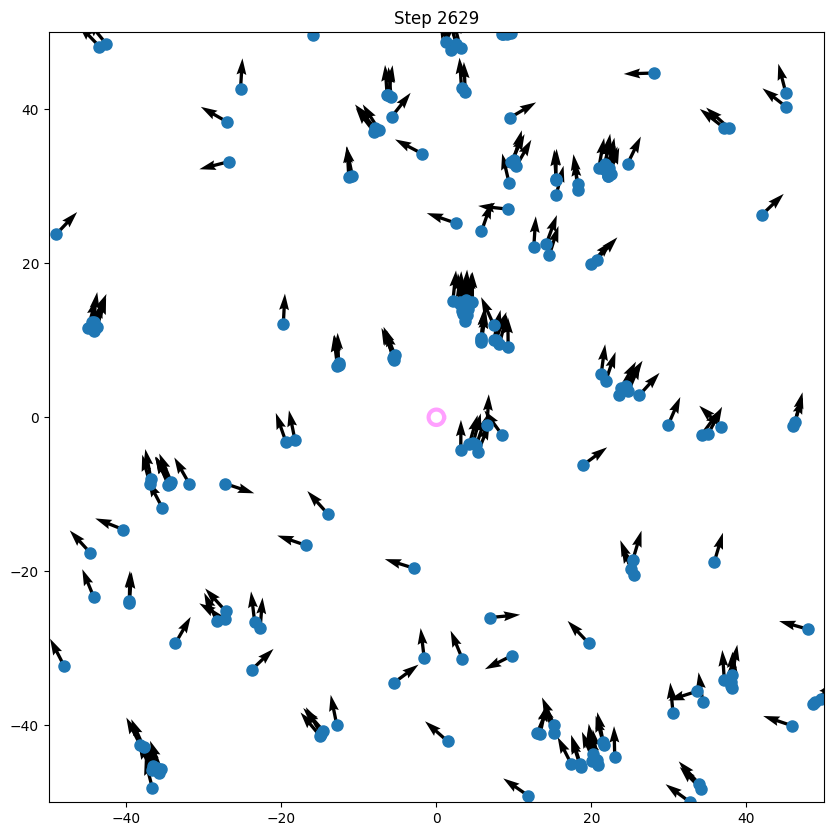

In [12]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import time

N_part = 200  # Number of particles.
L = 100  # Dimension of the squared arena.
v = 1  # Speed.
Rf = 1  # Flocking radius.
eta = 0.3  # Noise.  Try values: 0.01, 0.3, 1.0, 2 * np.pi
dt = 1  # Time step.

N_max_steps = 6000

psi = np.zeros(N_max_steps)  # Records the global alignment.
c = np.zeros(N_max_steps)  # Records the global clustering.

# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
theta = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]

# Initialize plot.
fig, ax = plt.subplots(figsize=(10, 10))

for step in range(N_max_steps):
    # Check whether plot configuration.
    if step % 1 == 0:
        ax.clear()  # Clear previous plot.
        ax.plot(x, y, '.', markersize=16)
        ax.quiver(x, y, np.cos(theta), np.sin(theta))
        ax.plot(Rf * np.cos(2 * np.pi * np.arange(360) / 360),
                Rf * np.sin(2 * np.pi * np.arange(360) / 360),
                '-', color='#FFA0FF', linewidth=3)
        ax.set_xlim([-L / 2, L / 2])
        ax.set_ylim([-L / 2, L / 2])
        ax.set_title(f'Step {step}')
        display(fig)  # Display updated plot.
        clear_output(wait=True)  # Clear previous output.
            
    psi[step] = global_alignment(theta)
    c[step] = global_clustering(x, y, Rf, L)
    
    # Calculate next theta from the rule.
    dtheta = eta * (np.random.rand(N_part) - 0.5) * dt
    theta = interaction(x, y, theta, Rf, L) + dtheta
    x = x + v * np.cos(theta)
    y = y + v * np.sin(theta)
    
    # Reflecting boundary conditions.
    x, y = pbc(x, y, L)

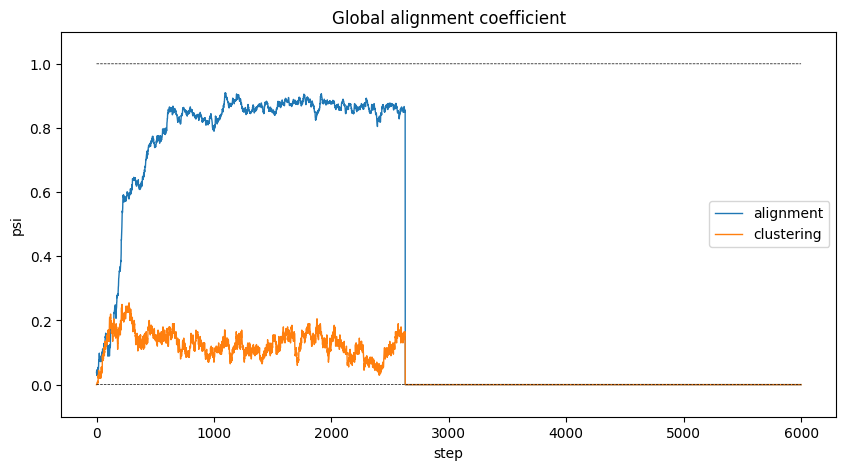

200


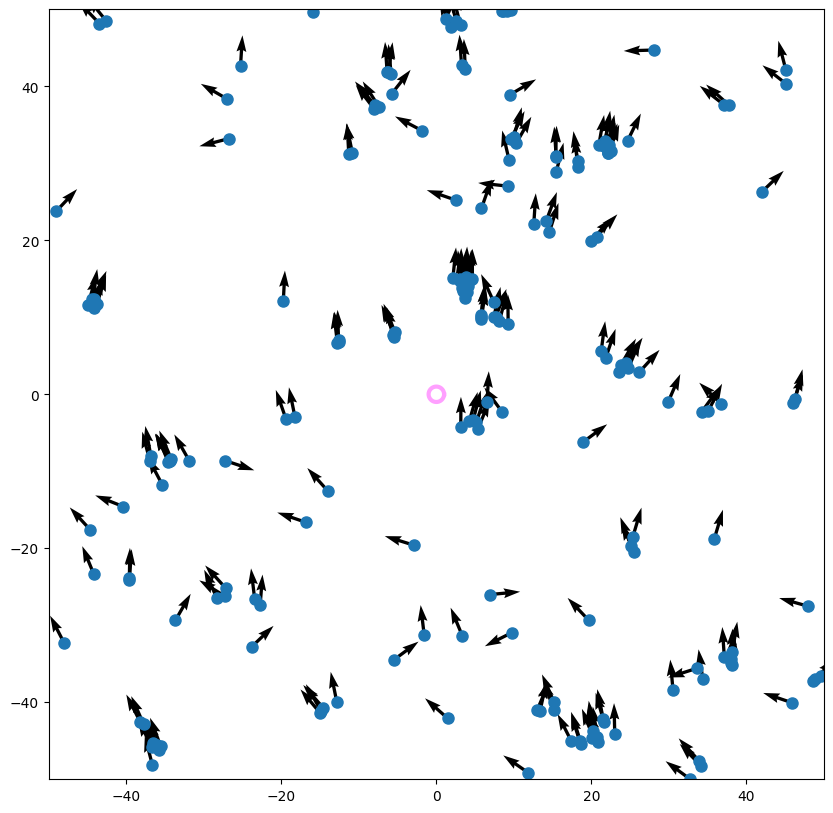

In [13]:
from matplotlib import pyplot as plt

# Plot the global alignment coefficient

plt.figure(figsize=(10, 5))
plt.plot(psi, '-', linewidth=1, label='alignment')
plt.plot(c, '-', linewidth=1, label='clustering')
plt.plot(0 * psi, '--', color='k', linewidth=0.5)
plt.plot(0 * psi + 1, '--', color='k', linewidth=0.5)
plt.title('Global alignment coefficient')
plt.legend()
plt.xlabel('step')
plt.ylabel('psi')
plt.ylim([-0.1, 1.1])
plt.show()


plt.figure(figsize=(10, 10))
plt.plot(x, y, '.', markersize=16 )
plt.quiver(x, y, np.cos(theta), np.sin(theta))
plt.plot(Rf * np.cos(2 * np.pi * np.arange(360) / 360), 
         Rf * np.sin(2 * np.pi * np.arange(360) / 360), 
         '-', color='#FFA0FF', linewidth=3 )
plt.xlim([- L / 2, L / 2])
plt.ylim([- L / 2, L / 2])

print(np.size(theta))